## Fetch the Data and Visualize Data

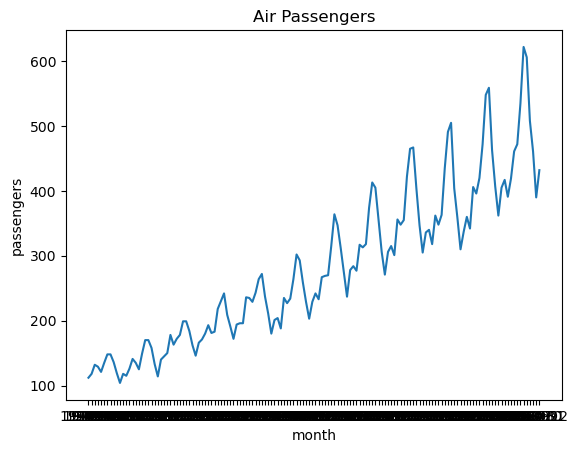

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

plt.plot(month, passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.title('Air Passengers')
plt.show()

## Clean trend and seasonality from data

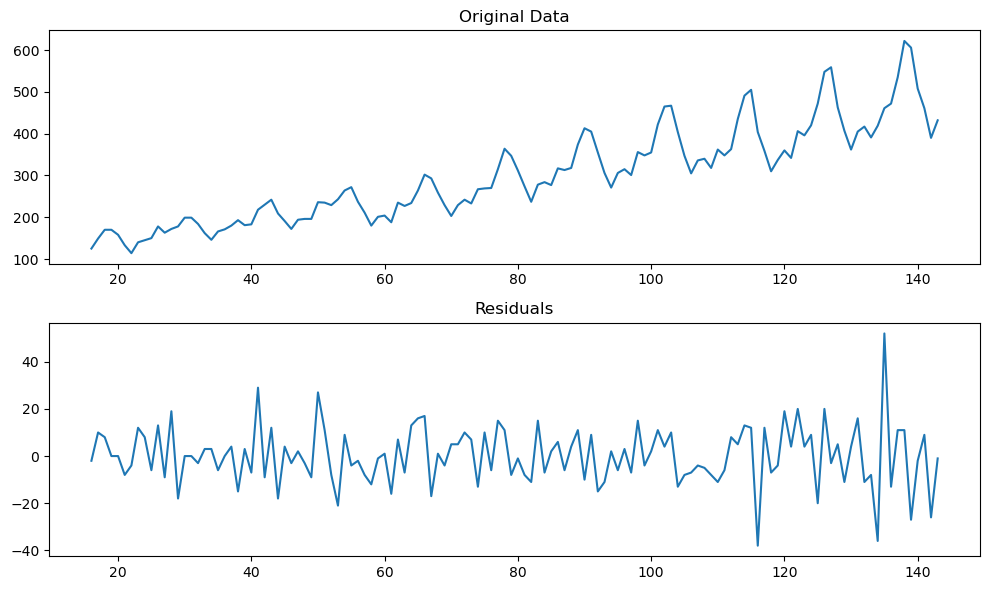

,Month,Passengers,Passengers_diff,Passengers_diff_seasonal,t-1,t-2,t-3
16,1950-05,125,-10.0,-2.0,-3.0,1.0,5.0
17,1950-06,149,24.0,10.0,-2.0,-3.0,1.0
18,1950-07,170,21.0,8.0,10.0,-2.0,-3.0
19,1950-08,170,0.0,0.0,8.0,10.0,-2.0
20,1950-09,158,-12.0,0.0,0.0,8.0,10.0
...,...,...,...,...,...,...,...
139,1960-08,606,-16.0,-27.0,11.0,11.0,-13.0
140,1960-09,508,-98.0,-2.0,-27.0,11.0,11.0
141,1960-10,461,-47.0,9.0,-2.0,-27.0,11.0
142,1960-11,390,-71.0,-26.0,9.0,-2.0,-27.0


In [2]:
data['Passengers'] = pd.to_numeric(data['Passengers'])

# p = 1
data['Passengers_diff'] = data['Passengers'].diff()

# d = 12
seasonal_period = 12
data['Passengers_diff_seasonal'] = data['Passengers_diff'].diff(seasonal_period)

# q = 3
data['t-1'] = data['Passengers_diff_seasonal'].shift(1)
data['t-2'] = data['Passengers_diff_seasonal'].shift(2)
data['t-3'] = data['Passengers_diff_seasonal'].shift(3)

# Drop NaN values
data = data.dropna()

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(data['Passengers'])
plt.title('Original Data')

plt.subplot(2, 1, 2)
plt.plot(data['Passengers_diff_seasonal'])
plt.title('Residuals')

plt.tight_layout()
plt.show()
data

In [3]:
import numpy as np

# Calculate the indices for the splits
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = int(len(data) * 0.15)

# Split the data
X_train = data[:train_size]
X_val = data[train_size:train_size+val_size]
X_test = data[train_size+val_size:]

y_train = data[:train_size]
y_val = data[train_size:train_size+val_size]
y_test = data[train_size+val_size:]

In [4]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X_train = X_train[['t-1', 't-2', 't-3']]
y_train = y_train['Passengers_diff_seasonal']

model = svm.SVR()
scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Train the model
model.fit(X_train, y_train)

SVR()

## BayesSearch

In [5]:
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
# from skopt.plots import plot_objective, plot_histogram
import skopt

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_space = {

    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'C': (1e-6, 1e+1, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'epsilon': (1e-6, 1e+6, 'log-uniform')
    }


kFold = KFold(n_splits=5, shuffle=True, random_state=10)

model.fit(X_train, y_train)

bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error', n_iter=50)

bayes_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = bayes_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['kernel'] = cv_results_df['params'].apply(lambda x: x['kernel'])
cv_results_df['C'] = cv_results_df['params'].apply(lambda x: x['C'])
cv_results_df['gamma'] = cv_results_df['params'].apply(lambda x: x['gamma'])
cv_results_df['epsilon'] = cv_results_df['params'].apply(lambda x: x['epsilon'])


print(cv_results_df[['mean_test_score', 'kernel', 'C', 'gamma', 'epsilon']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', bayes_search.best_params_)

best_model = bayes_search.best_estimator_


    mean_test_score   kernel         C      gamma        epsilon
0     -2.266517e+14     poly  0.001603   0.000001       0.000054
1     -1.162694e+15     poly  0.000002   0.032625      33.177887
2     -6.286515e+14     poly  3.008033   0.001283       0.173649
3     -1.162694e+15  sigmoid  0.004343   0.009027  727055.892442
4     -1.162694e+15  sigmoid  0.000006   0.000002    4197.600549
5     -1.027312e+15   linear  4.151248   0.013632       0.000023
6     -2.266415e+14      rbf  0.000648   0.000488       0.000150
7     -2.266517e+14     poly  0.104103   0.000012       0.297985
8     -1.162694e+15     poly  0.000006   0.000004   10026.650921
9     -1.162694e+15   linear  0.541307   0.003607  156500.968590
10    -2.266485e+14      rbf  0.008611   0.000001       0.015510
11    -2.266517e+14     poly  0.089022   0.000009       0.272498
12    -2.266430e+14      rbf  0.001027   0.000023       0.000092
13    -2.266517e+14     poly  0.073784   0.000007       0.238260
14    -2.266517e+14     p

In [6]:
import matplotlib.pyplot as plt

X_test = X_test[['t-1', 't-2', 't-3']]
y_test = y_test['Passengers_diff_seasonal']

predictions = best_model.predict(X_test)
X_test
predictions

array([ 0.25280898,  0.02743225,  0.43642182, -0.17390768,  0.43569308,
        0.02666772,  0.35296298,  0.05859452,  0.10174917,  0.38442652,
        0.13166023,  0.56387345, -0.4634873 ,  0.73565251, -0.20556689,
        0.2068392 ,  0.4850362 , -0.00154264,  0.21366995,  0.52571159])

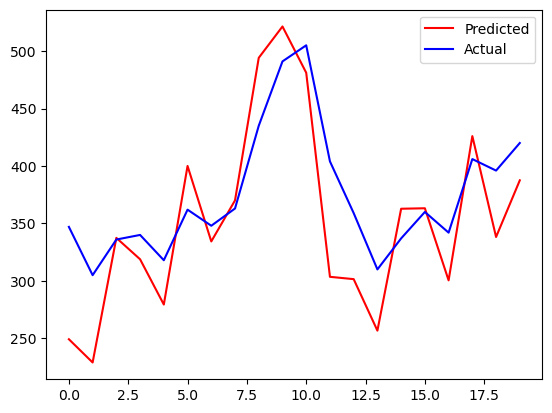

In [18]:
# Step 1: Convert the predictions from the difference scale back to the original scale
predictions_diff_series = pd.Series(predictions, index=X_test.index)
predictions_seasonal = predictions_diff_series.add(data['Passengers_diff'].iloc[train_size:train_size+len(predictions)].values)

# Step 2: Add the seasonal difference from 's' time periods ago to these forecasts
predictions_seasonal_series = pd.Series(predictions_seasonal, index=X_test.index)
predictions_original_scale = predictions_seasonal_series.add(data['Passengers'].shift(seasonal_period).iloc[train_size:train_size+len(predictions_seasonal)].values)

# Plot real vs predicted values
plt.plot(range(len(predictions_original_scale)), predictions_original_scale, color='red', label='Predicted')
plt.plot(range(len(y_test)), data['Passengers'].iloc[train_size:train_size+len(predictions)], color='blue', label='Actual')
plt.legend()
plt.show()


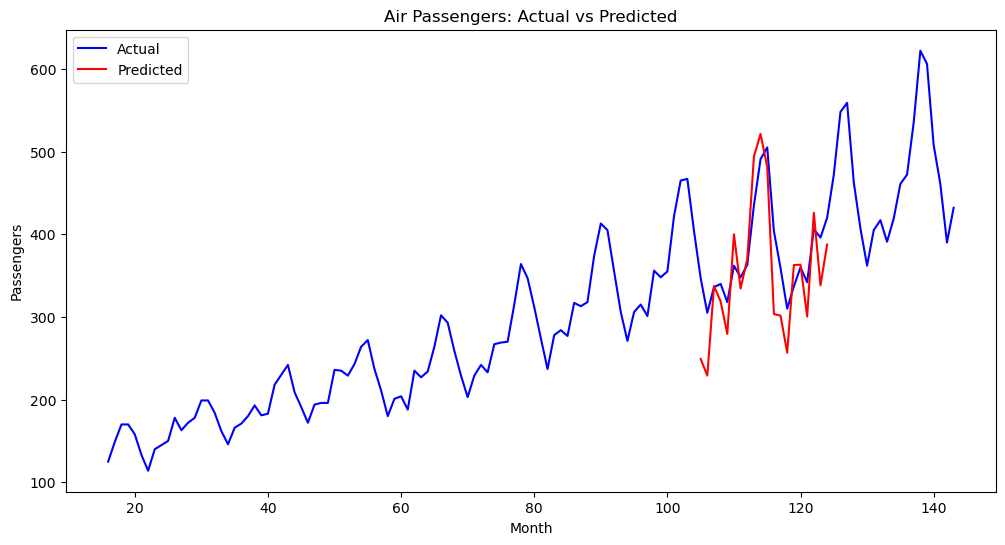

In [19]:
# Plotting the entire data series
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Passengers'], color='blue', label='Actual')

# Plotting the predicted values
predicted_index = data.iloc[train_size:train_size+len(predictions)].index
plt.plot(predicted_index, predictions_original_scale, color='red', label='Predicted')

plt.legend()
plt.title('Air Passengers: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)

print('Mean Squared Error on test set:', mse)

Mean Squared Error on test set: 366.39430343927813
